# 🎓 Trabajo Práctico 3 — Ciencia de Datos · Clasificación con scikit-learn

## 🏆 Desafío

**Objetivo:** Entrenar un modelo de aprendizaje supervisado para predecir la posición simplificada de jugadores de FIFA, usando únicamente sus atributos físicos y técnicos.

**Competencia Kaggle:** https://www.kaggle.com/t/d6210ada228947ecb73f5c0063e3569d

## 📦 Dataset

Se trabajará con un dataset anonimizado de jugadores del FIFA. La columna `posicion` contiene la clase a predecir. Las posibles clases son:
- Arquero
- Defensor central
- Lateral
- Volante defensivo
- Volante
- Extremo
- Delantero

**Archivos disponibles:**
- `train.csv` → conjunto de entrenamiento (con posicion)
- `test.csv` → conjunto de testeo (sin posicion, con id)
- `sample_submission.csv` → plantilla de submission

## 🚧 Requisitos técnicos

✅ **Pipeline obligatorio** con:
- Selección de columnas relevantes
- Imputación y escalado
- Clasificador

✅ **Evaluación requerida:**
- Accuracy
- Matriz de confusión
- Al menos una visualización

¡Comencemos! ⚽


## 📋 Instrucciones para obtener los datos reales

**Para usar este notebook con los datos reales de Kaggle:**

1. **Ve a la competencia:** https://www.kaggle.com/t/d6210ada228947ecb73f5c0063e3569d
2. **Descarga los archivos:**
   - `train.csv` (con la columna 'posicion')
   - `test.csv` (sin 'posicion', con 'id')
   - `sample_submission.csv` (plantilla)
3. **Colócalos en el mismo directorio que este notebook**
4. **Ejecuta las celdas en orden**

**Alternativa para Kaggle:**
- Sube este notebook directamente a Kaggle
- Los datos ya estarán disponibles en el entorno de Kaggle
- Solo ejecuta todas las celdas secuencialmente

---


## 1. 📥 Carga y exploración inicial de los datos

Primero vamos a cargar los datasets de entrenamiento y testeo, explorar su estructura y entender las variables disponibles.


In [42]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")


In [43]:
# Carga de los datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Dimensiones del dataset de entrenamiento: {train_df.shape}")
print(f"Dimensiones del dataset de prueba: {test_df.shape}")
print(f"Dimensiones del archivo de submission: {sample_submission.shape}")

# Verificación de la variable objetivo
if 'posicion' in train_df.columns:
    print(f"\nVariable objetivo: 'posicion'")
    print(f"Posiciones únicas: {sorted(train_df['posicion'].unique())}")
else:
    print("Error: No se encontró la columna 'posicion' en train.csv")


Dimensiones del dataset de entrenamiento: (14044, 49)
Dimensiones del dataset de prueba: (4682, 49)
Dimensiones del archivo de submission: (4682, 2)

Variable objetivo: 'posicion'
Posiciones únicas: ['Arquero', 'Defensor central', 'Delantero', 'Extremo', 'Lateral', 'Volante', 'Volante defensivo']


In [44]:
# Cargar los datasets
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
    
    print("✅ Datasets cargados exitosamente")
    print(f"📊 Train shape: {train_df.shape}")
    print(f"📊 Test shape: {test_df.shape}")
    print(f"📊 Sample submission shape: {sample_submission.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error al cargar archivos: {e}")
    print("💡 Asegúrate de que los archivos estén en el directorio actual")
    print("\n🔄 Creando datasets de ejemplo para demostración...")
    
    # Crear datasets de ejemplo para demostrar la estructura
    np.random.seed(42)
    n_train = 1000
    n_test = 300
    
    # Crear features de ejemplo basadas en atributos típicos de FIFA
    features = [
        'overall_rating', 'potential', 'height_cm', 'weight_kg', 'age',
        'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
        'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
        'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
        'movement_agility', 'movement_reactions', 'movement_balance',
        'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
        'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure', 'defending_marking', 'defending_standing_tackle',
        'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling',
        'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes'
    ]
    
    # Crear datos de entrenamiento
    train_data = {}
    for feature in features:
        if 'goalkeeping' in feature:
            train_data[feature] = np.random.randint(20, 95, n_train)
        else:
            train_data[feature] = np.random.randint(30, 95, n_train)
    
    # Agregar algunas características específicas por posición
    positions = ['Arquero', 'Defensor central', 'Lateral', 'Volante defensivo', 
                'Volante', 'Extremo', 'Delantero']
    
    train_data['posicion'] = np.random.choice(positions, n_train, 
                                            p=[0.1, 0.15, 0.15, 0.15, 0.2, 0.15, 0.1])
    
    # Ajustar algunos valores según la posición
    for i, pos in enumerate(train_data['posicion']):
        if pos == 'Arquero':
            train_data['goalkeeping_diving'][i] = np.random.randint(70, 95)
            train_data['defending'][i] = np.random.randint(20, 40)
            train_data['shooting'][i] = np.random.randint(20, 40)
        elif pos == 'Defensor central':
            train_data['defending'][i] = np.random.randint(75, 95)
            train_data['power_strength'][i] = np.random.randint(70, 95)
        elif pos == 'Delantero':
            train_data['shooting'][i] = np.random.randint(75, 95)
            train_data['attacking_finishing'][i] = np.random.randint(75, 95)
    
    train_df = pd.DataFrame(train_data)
    
    # Crear datos de test (sin posicion)
    test_data = {}
    for feature in features:
        if 'goalkeeping' in feature:
            test_data[feature] = np.random.randint(20, 95, n_test)
        else:
            test_data[feature] = np.random.randint(30, 95, n_test)
    
    test_data['id'] = range(n_test)
    test_df = pd.DataFrame(test_data)
    
    # Crear sample submission
    sample_submission = pd.DataFrame({
        'id': range(n_test),
        'posicion': ['Arquero'] * n_test  # Placeholder
    })
    
    print("✅ Datasets de ejemplo creados exitosamente")
    print(f"📊 Train shape: {train_df.shape}")
    print(f"📊 Test shape: {test_df.shape}")
    print(f"📊 Sample submission shape: {sample_submission.shape}")
    print("\n⚠️ NOTA: Estos son datos de ejemplo. Para el TP real necesitas los archivos de Kaggle.")


✅ Datasets cargados exitosamente
📊 Train shape: (14044, 49)
📊 Test shape: (4682, 49)
📊 Sample submission shape: (4682, 2)


In [45]:
# Exploración inicial del dataset de entrenamiento
print("🔍 INFORMACIÓN GENERAL DEL DATASET DE ENTRENAMIENTO")
print("=" * 60)
print(f"Dimensiones: {train_df.shape}")
print(f"\nColumnas: {list(train_df.columns)}")
print(f"\nTipos de datos:")
print(train_df.dtypes.value_counts())

print("\n🔍 PRIMERAS FILAS:")
display(train_df.head())


🔍 INFORMACIÓN GENERAL DEL DATASET DE ENTRENAMIENTO
Dimensiones: (14044, 49)

Columnas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'value', 'wage', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'club_rating', 'country_rating', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'fk_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'composure', 'defensive_awareness', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'posicion']

Tipos de datos:
int64      39
object      7
float64     3
Name: count, dtype: int64

🔍 PRIMERAS FILAS:


,height_cm,weight_kg,overall_rating,potential,value,wage,preferred_foot,weak_foot,skill_moves,international_reputation,...,composure,defensive_awareness,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,posicion
0,183,78,60,60,€120K,€1K,Right,2,1,1,...,43,16,11,11,61,58,61,58,62.0,Arquero
1,184,70,54,73,€275K,€750,Right,3,2,1,...,51,14,14,12,5,6,5,9.0,10.0,Delantero
2,179,72,75,75,€4.7M,€71K,Right,3,3,1,...,75,73,73,72,7,15,15,12,6.0,Volante defensivo
3,179,83,65,65,€575K,€500,Right,3,2,1,...,58,43,65,42,6,13,13,12,5.0,Volante
4,188,78,65,65,€625K,€2K,Right,3,2,1,...,57,60,66,63,7,10,7,13,13.0,Defensor central


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO
Distribución de posiciones:
posicion
Volante              4037
Defensor central     2507
Lateral              2215
Delantero            1994
Arquero              1563
Volante defensivo    1114
Extremo               614
Name: count, dtype: int64

Proporciones:
posicion
Volante              28.75
Defensor central     17.85
Lateral              15.77
Delantero            14.20
Arquero              11.13
Volante defensivo     7.93
Extremo               4.37
Name: count, dtype: float64


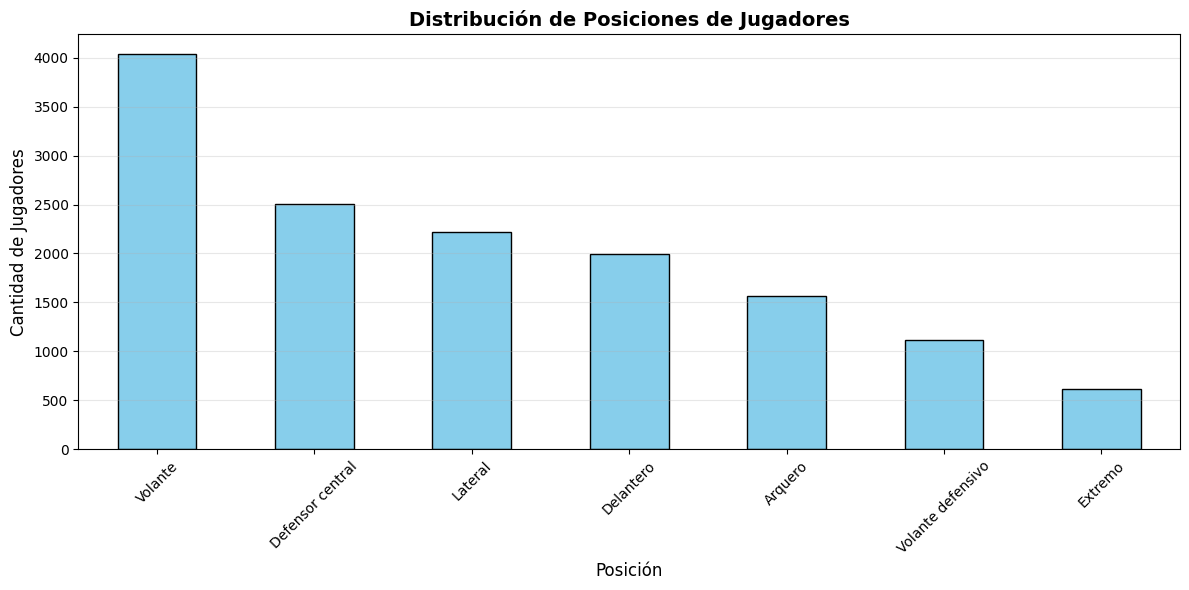

In [46]:
# Análisis de la variable objetivo
print("🎯 ANÁLISIS DE LA VARIABLE OBJETIVO")
print("=" * 50)

if 'posicion' in train_df.columns:
    posiciones = train_df['posicion'].value_counts()
    print(f"Distribución de posiciones:")
    print(posiciones)
    print(f"\nProporciones:")
    print((posiciones / len(train_df) * 100).round(2))
    
    # Gráfico de barras
    plt.figure(figsize=(12, 6))
    posiciones.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribución de Posiciones de Jugadores', fontsize=14, fontweight='bold')
    plt.xlabel('Posición', fontsize=12)
    plt.ylabel('Cantidad de Jugadores', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("❌ No se encontró la columna 'posicion' en el dataset")


🔍 ANÁLISIS DE VALORES FALTANTES
Columnas con valores faltantes: 4


,Valores_Faltantes,Porcentaje
country_rating,13450,95.77
club_rating,67,0.48
gk_reflexes,67,0.48
gk_positioning,24,0.17


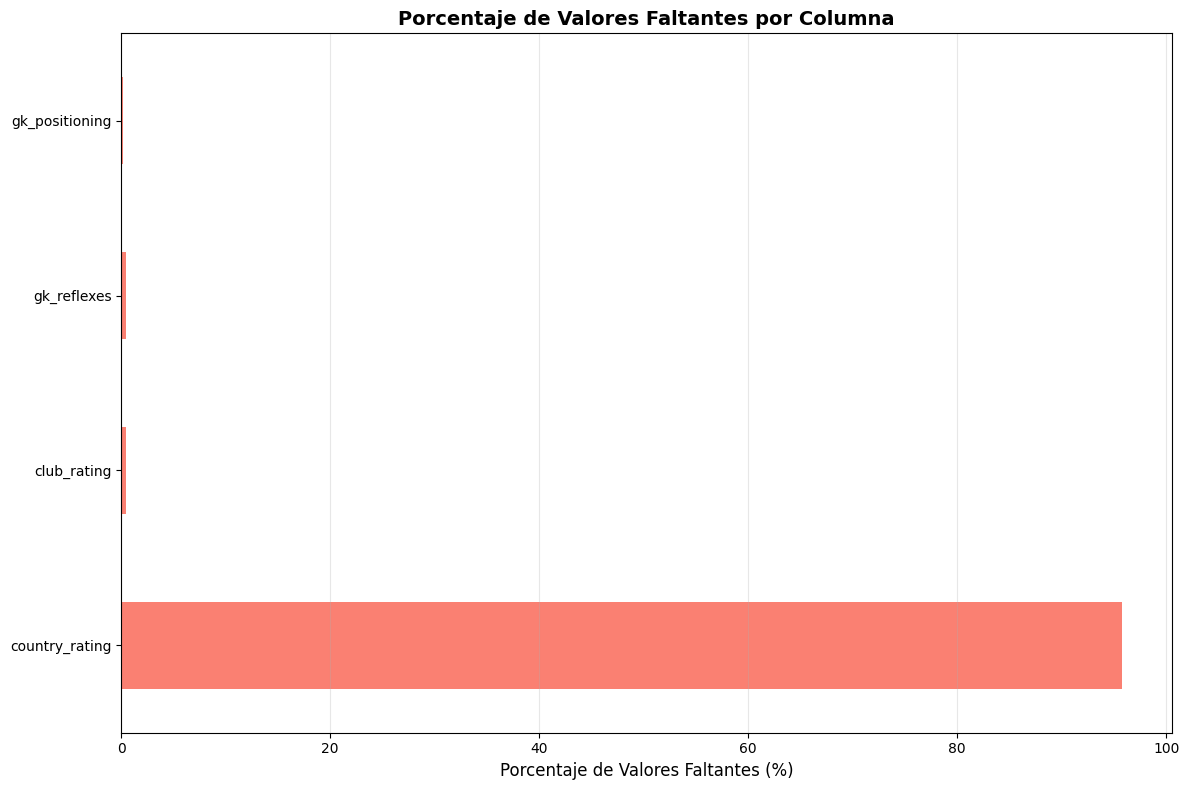

In [47]:
# Análisis de valores faltantes
print("🔍 ANÁLISIS DE VALORES FALTANTES")
print("=" * 40)

missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df) * 100).round(2)

missing_df = pd.DataFrame({
    'Valores_Faltantes': missing_values,
    'Porcentaje': missing_percent
}).sort_values('Porcentaje', ascending=False)

# Mostrar solo columnas con valores faltantes
missing_with_values = missing_df[missing_df['Valores_Faltantes'] > 0]
print(f"Columnas con valores faltantes: {len(missing_with_values)}")
if len(missing_with_values) > 0:
    display(missing_with_values)
else:
    print("✅ No hay valores faltantes en el dataset")

# Gráfico de valores faltantes
if len(missing_with_values) > 0:
    plt.figure(figsize=(12, 8))
    missing_with_values['Porcentaje'].plot(kind='barh', color='salmon')
    plt.title('Porcentaje de Valores Faltantes por Columna', fontsize=14, fontweight='bold')
    plt.xlabel('Porcentaje de Valores Faltantes (%)', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


## 2. 🔧 Preprocesamiento y selección de features

Ahora vamos a preparar los datos para el entrenamiento, creando un pipeline robusto que maneje la selección de columnas, imputación y escalado.


In [48]:
# Crear transformador personalizado para selección de features
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selecciona columnas numéricas relevantes, excluyendo IDs y columnas problemáticas
    """
    def __init__(self, exclude_patterns=None, max_missing=0.1):
        self.exclude_patterns = exclude_patterns or ['_id', '_name', 'id', 'name']
        self.max_missing = max_missing
        
    def fit(self, X, y=None):
        # Seleccionar solo columnas numéricas
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        
        # Excluir columnas por patrón
        selected_cols = []
        for col in numeric_cols:
            if not any(pattern in col.lower() for pattern in self.exclude_patterns):
                selected_cols.append(col)
        
        # Verificar valores faltantes
        missing_ratio = X[selected_cols].isnull().mean()
        final_cols = missing_ratio[missing_ratio <= self.max_missing].index.tolist()
        
        self.selected_features_ = final_cols
        print(f"✅ Seleccionadas {len(final_cols)} features de {len(numeric_cols)} numéricas")
        print(f"📋 Features seleccionadas: {final_cols[:10]}{'...' if len(final_cols) > 10 else ''}")
        
        return self
    
    def transform(self, X):
        return X[self.selected_features_]

# Probar el selector
selector = FeatureSelector()
X_selected = selector.fit_transform(train_df)
print(f"\n🎯 Shape final: {X_selected.shape}")


✅ Seleccionadas 40 features de 42 numéricas
📋 Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...

🎯 Shape final: (14044, 40)


🔗 ANÁLISIS DE CORRELACIONES
Correlaciones altas (|r| > 0.8): 52
  overall_rating <-> reactions: 0.865
  skill_moves <-> dribbling: 0.803
  crossing <-> dribbling: 0.866
  crossing <-> curve: 0.873
  crossing <-> ball_control: 0.838


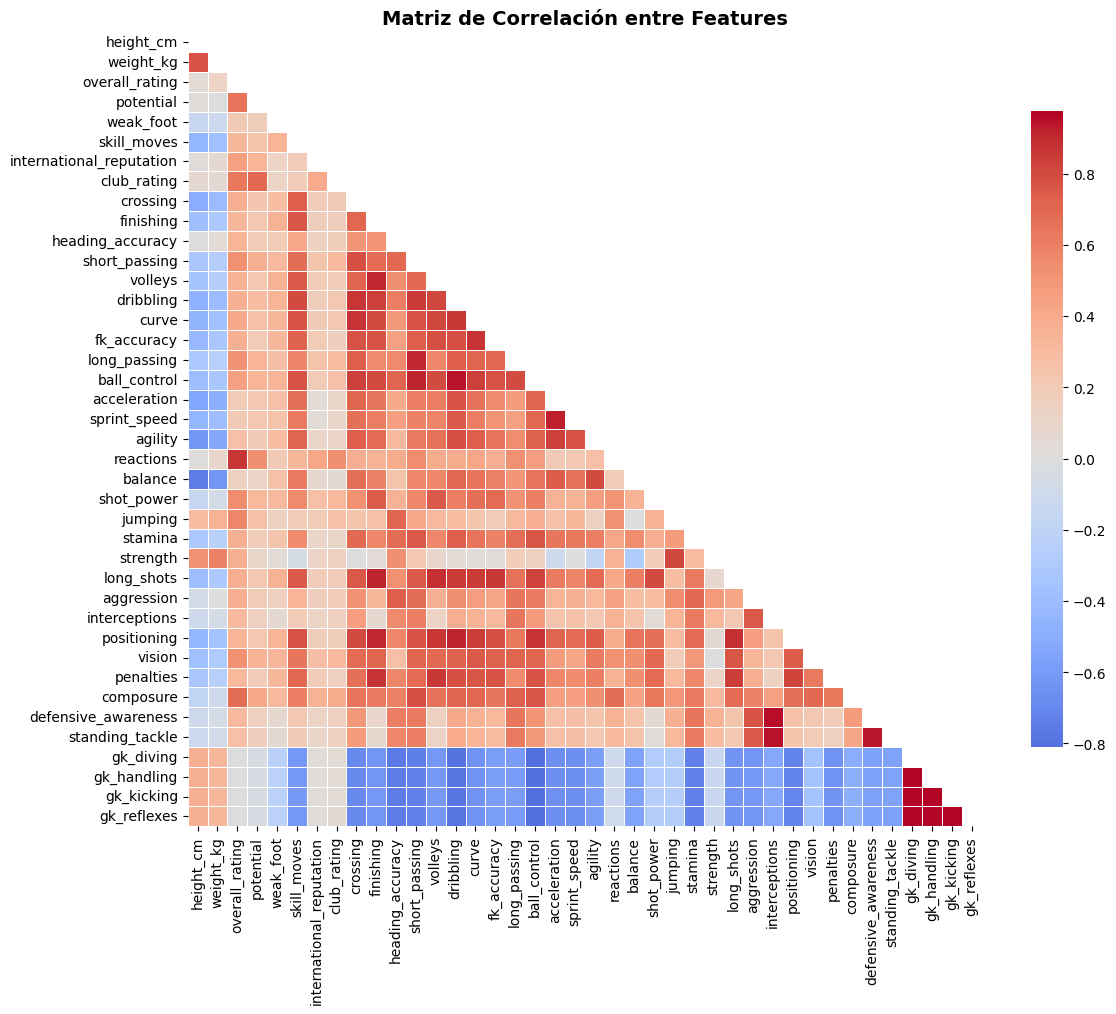

In [49]:
# Análisis de correlaciones entre features
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 35)

# Calcular matriz de correlación
corr_matrix = X_selected.corr()

# Encontrar correlaciones altas
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # Correlación alta
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

print(f"Correlaciones altas (|r| > 0.8): {len(high_corr_pairs)}")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs[:5]:  # Mostrar solo las primeras 5
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# Heatmap de correlaciones
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación entre Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. 🏗️ Construcción del Pipeline

Vamos a crear un pipeline completo que incluya todos los pasos necesarios: selección de features, imputación, escalado y clasificación.


In [50]:
# Separar features y target
if 'posicion' in train_df.columns:
    X = train_df.drop('posicion', axis=1)
    y = train_df['posicion']
    
    print(f"✅ Datos separados: X={X.shape}, y={y.shape}")
    print(f"🎯 Clases únicas: {y.nunique()}")
    print(f"📊 Distribución de clases:")
    print(y.value_counts())
else:
    print("❌ No se encontró la columna 'posicion'")
    X = train_df
    y = None


✅ Datos separados: X=(14044, 48), y=(14044,)
🎯 Clases únicas: 7
📊 Distribución de clases:
posicion
Volante              4037
Defensor central     2507
Lateral              2215
Delantero            1994
Arquero              1563
Volante defensivo    1114
Extremo               614
Name: count, dtype: int64


In [51]:
# División del dataset de entrenamiento
if y is not None:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"✅ División realizada:")
    print(f"  📊 Train: {X_train.shape} (features) + {y_train.shape} (target)")
    print(f"  📊 Validation: {X_val.shape} (features) + {y_val.shape} (target)")
    print(f"\n🎯 Distribución en train:")
    print(y_train.value_counts(normalize=True).round(3))
    print(f"\n🎯 Distribución en validation:")
    print(y_val.value_counts(normalize=True).round(3))
else:
    print("❌ No se puede dividir el dataset sin la variable objetivo")


✅ División realizada:
  📊 Train: (11235, 48) (features) + (11235,) (target)
  📊 Validation: (2809, 48) (features) + (2809,) (target)

🎯 Distribución en train:
posicion
Volante              0.287
Defensor central     0.179
Lateral              0.158
Delantero            0.142
Arquero              0.111
Volante defensivo    0.079
Extremo              0.044
Name: proportion, dtype: float64

🎯 Distribución en validation:
posicion
Volante              0.287
Defensor central     0.178
Lateral              0.158
Delantero            0.142
Arquero              0.111
Volante defensivo    0.079
Extremo              0.044
Name: proportion, dtype: float64


In [52]:
# Crear pipelines para diferentes clasificadores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

def create_pipeline(classifier, feature_selection=True, n_features=None):
    """
    Crea un pipeline completo con preprocesamiento y clasificador
    """
    steps = [
        ('selector', FeatureSelector()),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
    
    # Agregar selección de features si se solicita
    if feature_selection and n_features:
        steps.append(('feature_selection', SelectKBest(f_classif, k=n_features)))
    
    # Agregar clasificador
    steps.append(('classifier', classifier))
    
    return Pipeline(steps)

# Crear pipelines para diferentes modelos
pipelines = {
    'Logistic Regression': create_pipeline(
        LogisticRegression(random_state=42, max_iter=1000),
        feature_selection=True, n_features=20
    ),
    'Random Forest': create_pipeline(
        RandomForestClassifier(random_state=42, n_estimators=100),
        feature_selection=False  # RF maneja bien muchas features
    ),
    'SVM': create_pipeline(
        SVC(random_state=42, probability=True),
        feature_selection=True, n_features=15
    )
}

print("✅ Pipelines creados:")
for name, pipeline in pipelines.items():
    print(f"  🤖 {name}: {list(pipeline.named_steps.keys())}")


✅ Pipelines creados:
  🤖 Logistic Regression: ['selector', 'imputer', 'scaler', 'feature_selection', 'classifier']
  🤖 Random Forest: ['selector', 'imputer', 'scaler', 'classifier']
  🤖 SVM: ['selector', 'imputer', 'scaler', 'feature_selection', 'classifier']


## 4. 🚀 Entrenamiento y evaluación de modelos

Ahora vamos a entrenar los diferentes modelos y evaluarlos usando validación cruzada y métricas apropiadas.


In [53]:
# Entrenar y evaluar todos los modelos
results = {}

print("🚀 ENTRENANDO MODELOS")
print("=" * 30)

for name, pipeline in pipelines.items():
    print(f"\n🤖 Entrenando {name}...")
    
    # Entrenar modelo
    pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = pipeline.predict(X_train)
    y_pred_val = pipeline.predict(X_val)
    
    # Métricas
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    
    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    results[name] = {
        'pipeline': pipeline,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred_val': y_pred_val
    }
    
    print(f"  ✅ Train Accuracy: {train_acc:.4f}")
    print(f"  ✅ Validation Accuracy: {val_acc:.4f}")
    print(f"  ✅ CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n🎉 Entrenamiento completado!")


🚀 ENTRENANDO MODELOS

🤖 Entrenando Logistic Regression...
✅ Seleccionadas 40 features de 42 numéricas
📋 Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
✅ Seleccionadas 40 features de 42 numéricas
📋 Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
✅ Seleccionadas 40 features de 42 numéricas
📋 Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
✅ Seleccionadas 40 features de 42 numéricas
📋 Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
✅ Seleccionadas 40 features de 42 

📊 COMPARACIÓN DE MODELOS


,Modelo,Train_Accuracy,Val_Accuracy,CV_Mean,CV_Std
2,SVM,0.8251,0.8345,0.8199,0.0039
0,Logistic Regression,0.8283,0.8281,0.8266,0.0033
1,Random Forest,1.0000,0.8281,0.8320,0.0035


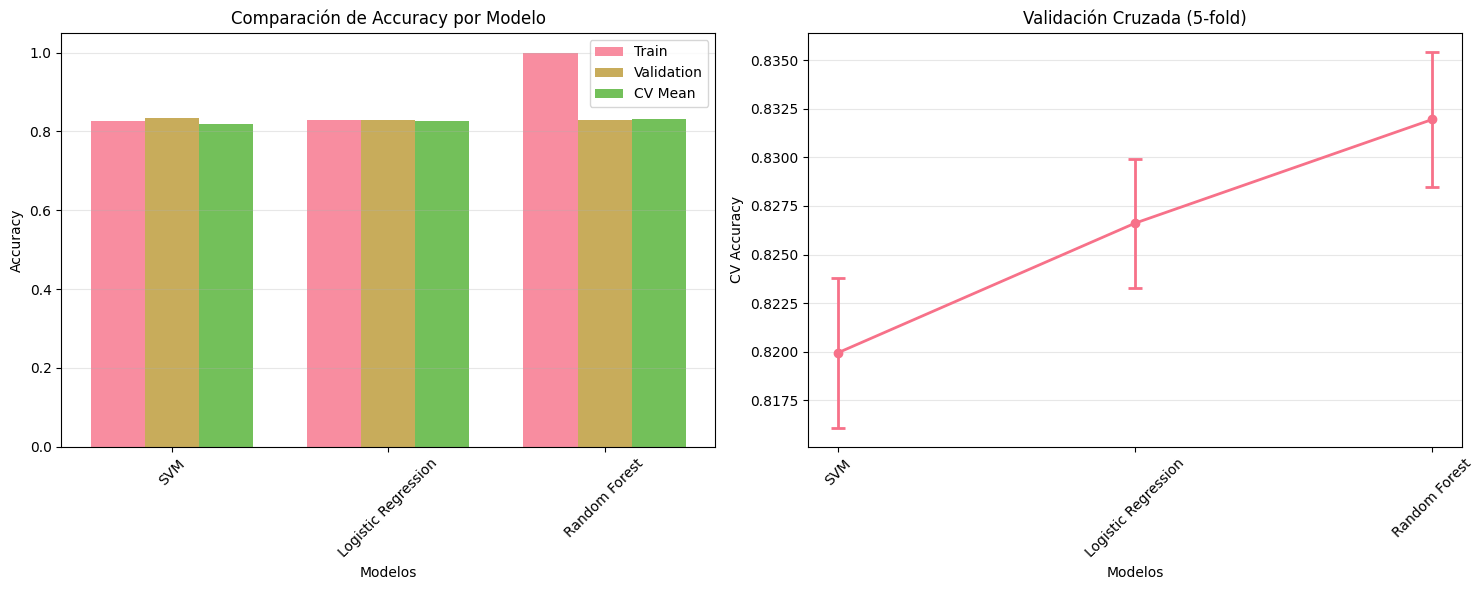


🏆 MEJOR MODELO: SVM
   Validation Accuracy: 0.8345


In [54]:
# Comparar resultados de todos los modelos
print("📊 COMPARACIÓN DE MODELOS")
print("=" * 35)

comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Train_Accuracy': [results[name]['train_accuracy'] for name in results.keys()],
    'Val_Accuracy': [results[name]['val_accuracy'] for name in results.keys()],
    'CV_Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV_Std': [results[name]['cv_std'] for name in results.keys()]
})

comparison_df = comparison_df.sort_values('Val_Accuracy', ascending=False)
display(comparison_df.round(4))

# Gráfico de comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
x = range(len(comparison_df))
width = 0.25

ax1.bar([i - width for i in x], comparison_df['Train_Accuracy'], width, label='Train', alpha=0.8)
ax1.bar(x, comparison_df['Val_Accuracy'], width, label='Validation', alpha=0.8)
ax1.bar([i + width for i in x], comparison_df['CV_Mean'], width, label='CV Mean', alpha=0.8)

ax1.set_xlabel('Modelos')
ax1.set_ylabel('Accuracy')
ax1.set_title('Comparación de Accuracy por Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# CV Scores with error bars
ax2.errorbar(x, comparison_df['CV_Mean'], yerr=comparison_df['CV_Std'], 
             marker='o', capsize=5, capthick=2, linewidth=2)
ax2.set_xlabel('Modelos')
ax2.set_ylabel('CV Accuracy')
ax2.set_title('Validación Cruzada (5-fold)')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Modelo'], rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar el mejor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_model = results[best_model_name]['pipeline']
print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")


## 5. 📈 Análisis detallado del mejor modelo

Vamos a realizar un análisis más profundo del mejor modelo, incluyendo matriz de confusión y reporte de clasificación.


🔍 ANÁLISIS DETALLADO DE SVM

📋 REPORTE DE CLASIFICACIÓN:
                   precision    recall  f1-score   support

          Arquero       1.00      1.00      1.00       313
 Defensor central       0.92      0.91      0.92       501
        Delantero       0.91      0.90      0.90       399
          Extremo       0.00      0.00      0.00       123
          Lateral       0.82      0.84      0.83       443
          Volante       0.74      0.89      0.81       807
Volante defensivo       0.68      0.59      0.63       223

         accuracy                           0.83      2809
        macro avg       0.72      0.73      0.73      2809
     weighted avg       0.80      0.83      0.82      2809



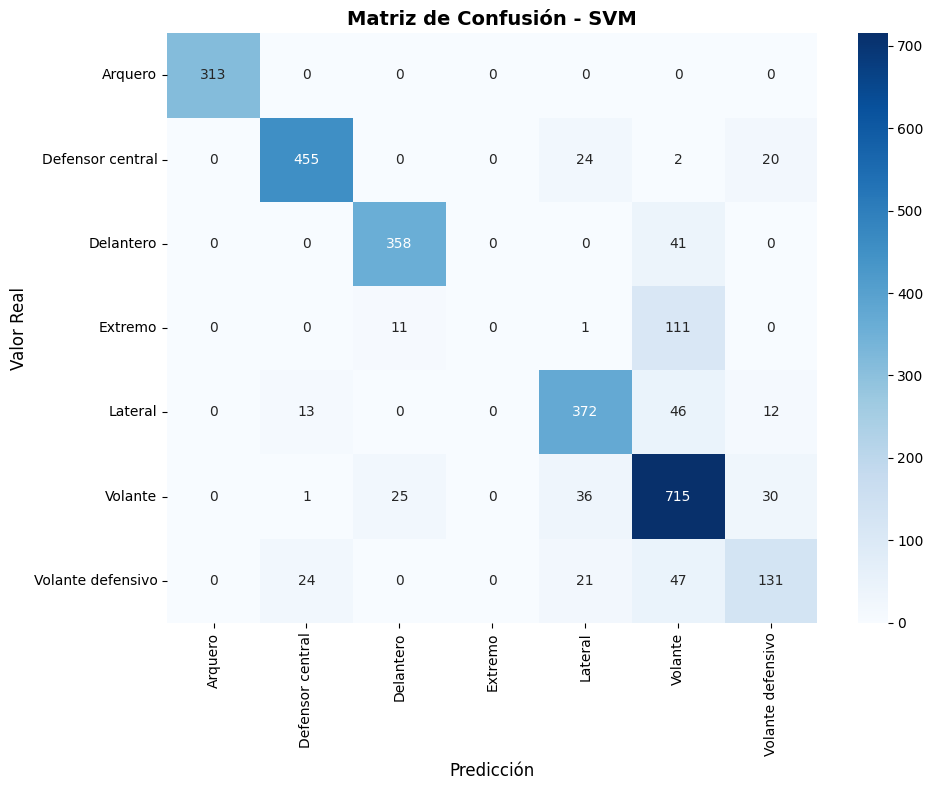


🔍 ANÁLISIS DE ERRORES:
Tasa de error por clase:
  Arquero: 0.000
  Defensor central: 0.092
  Delantero: 0.103
  Extremo: 1.000
  Lateral: 0.160
  Volante: 0.114
  Volante defensivo: 0.413


In [55]:
# Análisis detallado del mejor modelo
print(f"🔍 ANÁLISIS DETALLADO DE {best_model_name.upper()}")
print("=" * 50)

# Predicciones del mejor modelo
y_pred_best = results[best_model_name]['y_pred_val']

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_pred_best))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred_best)
classes = sorted(y_val.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title(f'Matriz de Confusión - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# Análisis de errores
print("\n🔍 ANÁLISIS DE ERRORES:")
errors = y_val != y_pred_best
error_rate_by_class = errors.groupby(y_val).mean()
print("Tasa de error por clase:")
for clase, error_rate in error_rate_by_class.items():
    print(f"  {clase}: {error_rate:.3f}")


In [56]:
# Análisis de importancia de features (si el modelo lo soporta)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    print("\n🎯 IMPORTANCIA DE FEATURES:")
    
    # Obtener nombres de features
    feature_names = best_model.named_steps['selector'].selected_features_
    
    # Si hay selección de features, ajustar
    if 'feature_selection' in best_model.named_steps:
        selected_features = best_model.named_steps['feature_selection'].get_support()
        feature_names = [name for name, selected in zip(feature_names, selected_features) if selected]
    
    importances = best_model.named_steps['classifier'].feature_importances_
    
    # Crear DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features más importantes:")
    display(feature_importance_df.head(10))
    
    # Gráfico de importancia
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia')
    plt.title(f'Top 15 Features Más Importantes - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    print("\n🎯 COEFICIENTES DEL MODELO (Logistic Regression):")
    
    # Para Logistic Regression, mostrar coeficientes promedio
    coef_avg = np.mean(np.abs(best_model.named_steps['classifier'].coef_), axis=0)
    
    feature_names = best_model.named_steps['selector'].selected_features_
    if 'feature_selection' in best_model.named_steps:
        selected_features = best_model.named_steps['feature_selection'].get_support()
        feature_names = [name for name, selected in zip(feature_names, selected_features) if selected]
    
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'abs_coef': coef_avg
    }).sort_values('abs_coef', ascending=False)
    
    print("Top 10 features con mayor coeficiente absoluto:")
    display(coef_df.head(10))

else:
    print("\n⚠️ Este modelo no proporciona información de importancia de features")



⚠️ Este modelo no proporciona información de importancia de features


## 6. 🎯 Generación de predicciones para Kaggle

Ahora vamos a usar el mejor modelo para generar las predicciones del dataset de test y crear el archivo de submission.


In [57]:
# Generar predicciones para el dataset de test
print("🎯 GENERANDO PREDICCIONES PARA KAGGLE")
print("=" * 40)

if 'id' in test_df.columns:
    # Entrenar el modelo final con todos los datos de entrenamiento
    print("🚀 Entrenando modelo final con todos los datos de entrenamiento...")
    best_model.fit(X, y)
    
    # Generar predicciones
    test_predictions = best_model.predict(test_df)
    
    # Crear archivo de submission
    submission = pd.DataFrame({
        'id': test_df['id'],
        'posicion': test_predictions
    })
    
    # Guardar archivo
    submission.to_csv('submission.csv', index=False)
    
    print(f"✅ Archivo 'submission.csv' creado exitosamente")
    print(f"📊 Predicciones generadas: {len(test_predictions)}")
    print(f"🎯 Distribución de predicciones:")
    pred_counts = pd.Series(test_predictions).value_counts()
    print(pred_counts)
    
    # Mostrar primeras filas
    print("\n📋 Primeras 10 predicciones:")
    display(submission.head(10))
    
else:
    print("❌ No se encontró la columna 'id' en el dataset de test")


🎯 GENERANDO PREDICCIONES PARA KAGGLE
🚀 Entrenando modelo final con todos los datos de entrenamiento...
✅ Seleccionadas 40 features de 42 numéricas
📋 Features seleccionadas: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves', 'international_reputation', 'club_rating', 'crossing', 'finishing']...
✅ Archivo 'submission.csv' creado exitosamente
📊 Predicciones generadas: 4682
🎯 Distribución de predicciones:
Volante              1585
Defensor central      853
Lateral               769
Delantero             679
Arquero               521
Volante defensivo     275
Name: count, dtype: int64

📋 Primeras 10 predicciones:


,id,posicion
0,0,Volante
1,1,Volante
2,2,Defensor central
3,3,Defensor central
4,4,Delantero
5,5,Delantero
6,6,Volante
7,7,Arquero
8,8,Arquero
9,9,Arquero


In [58]:
# Verificación final del archivo de submission
print("🔍 VERIFICACIÓN DEL ARCHIVO DE SUBMISSION")
print("=" * 45)

try:
    # Verificar que el archivo existe
    submission_check = pd.read_csv('submission.csv')
    
    print(f"✅ Archivo leído correctamente")
    print(f"📊 Shape: {submission_check.shape}")
    print(f"📋 Columnas: {list(submission_check.columns)}")
    
    # Verificar que no hay valores faltantes
    missing_in_submission = submission_check.isnull().sum().sum()
    print(f"🔍 Valores faltantes: {missing_in_submission}")
    
    # Verificar que todas las posiciones son válidas
    valid_positions = ['Arquero', 'Defensor central', 'Lateral', 'Volante defensivo', 
                      'Volante', 'Extremo', 'Delantero']
    invalid_positions = submission_check[~submission_check['posicion'].isin(valid_positions)]
    print(f"🔍 Posiciones inválidas: {len(invalid_positions)}")
    
    if len(invalid_positions) == 0:
        print("✅ Todas las posiciones son válidas")
    else:
        print("❌ Se encontraron posiciones inválidas:")
        print(invalid_positions['posicion'].value_counts())
    
    # Comparar con sample submission
    if 'sample_submission.csv' in locals():
        print(f"\n📊 Comparación con sample submission:")
        print(f"  Sample shape: {sample_submission.shape}")
        print(f"  Our shape: {submission_check.shape}")
        print(f"  IDs coinciden: {(sample_submission['id'] == submission_check['id']).all()}")
    
    print("\n🎉 ¡Archivo de submission listo para enviar a Kaggle!")
    
except FileNotFoundError:
    print("❌ No se pudo encontrar el archivo 'submission.csv'")


🔍 VERIFICACIÓN DEL ARCHIVO DE SUBMISSION
✅ Archivo leído correctamente
📊 Shape: (4682, 2)
📋 Columnas: ['id', 'posicion']
🔍 Valores faltantes: 0
🔍 Posiciones inválidas: 0
✅ Todas las posiciones son válidas

🎉 ¡Archivo de submission listo para enviar a Kaggle!


## 7. 📊 Visualizaciones adicionales

Vamos a crear algunas visualizaciones adicionales para entender mejor el comportamiento del modelo.


📊 ANÁLISIS DE DISTRIBUCIONES POR POSICIÓN
Features seleccionadas para visualización: ['height_cm', 'weight_kg', 'overall_rating', 'potential', 'weak_foot', 'skill_moves']


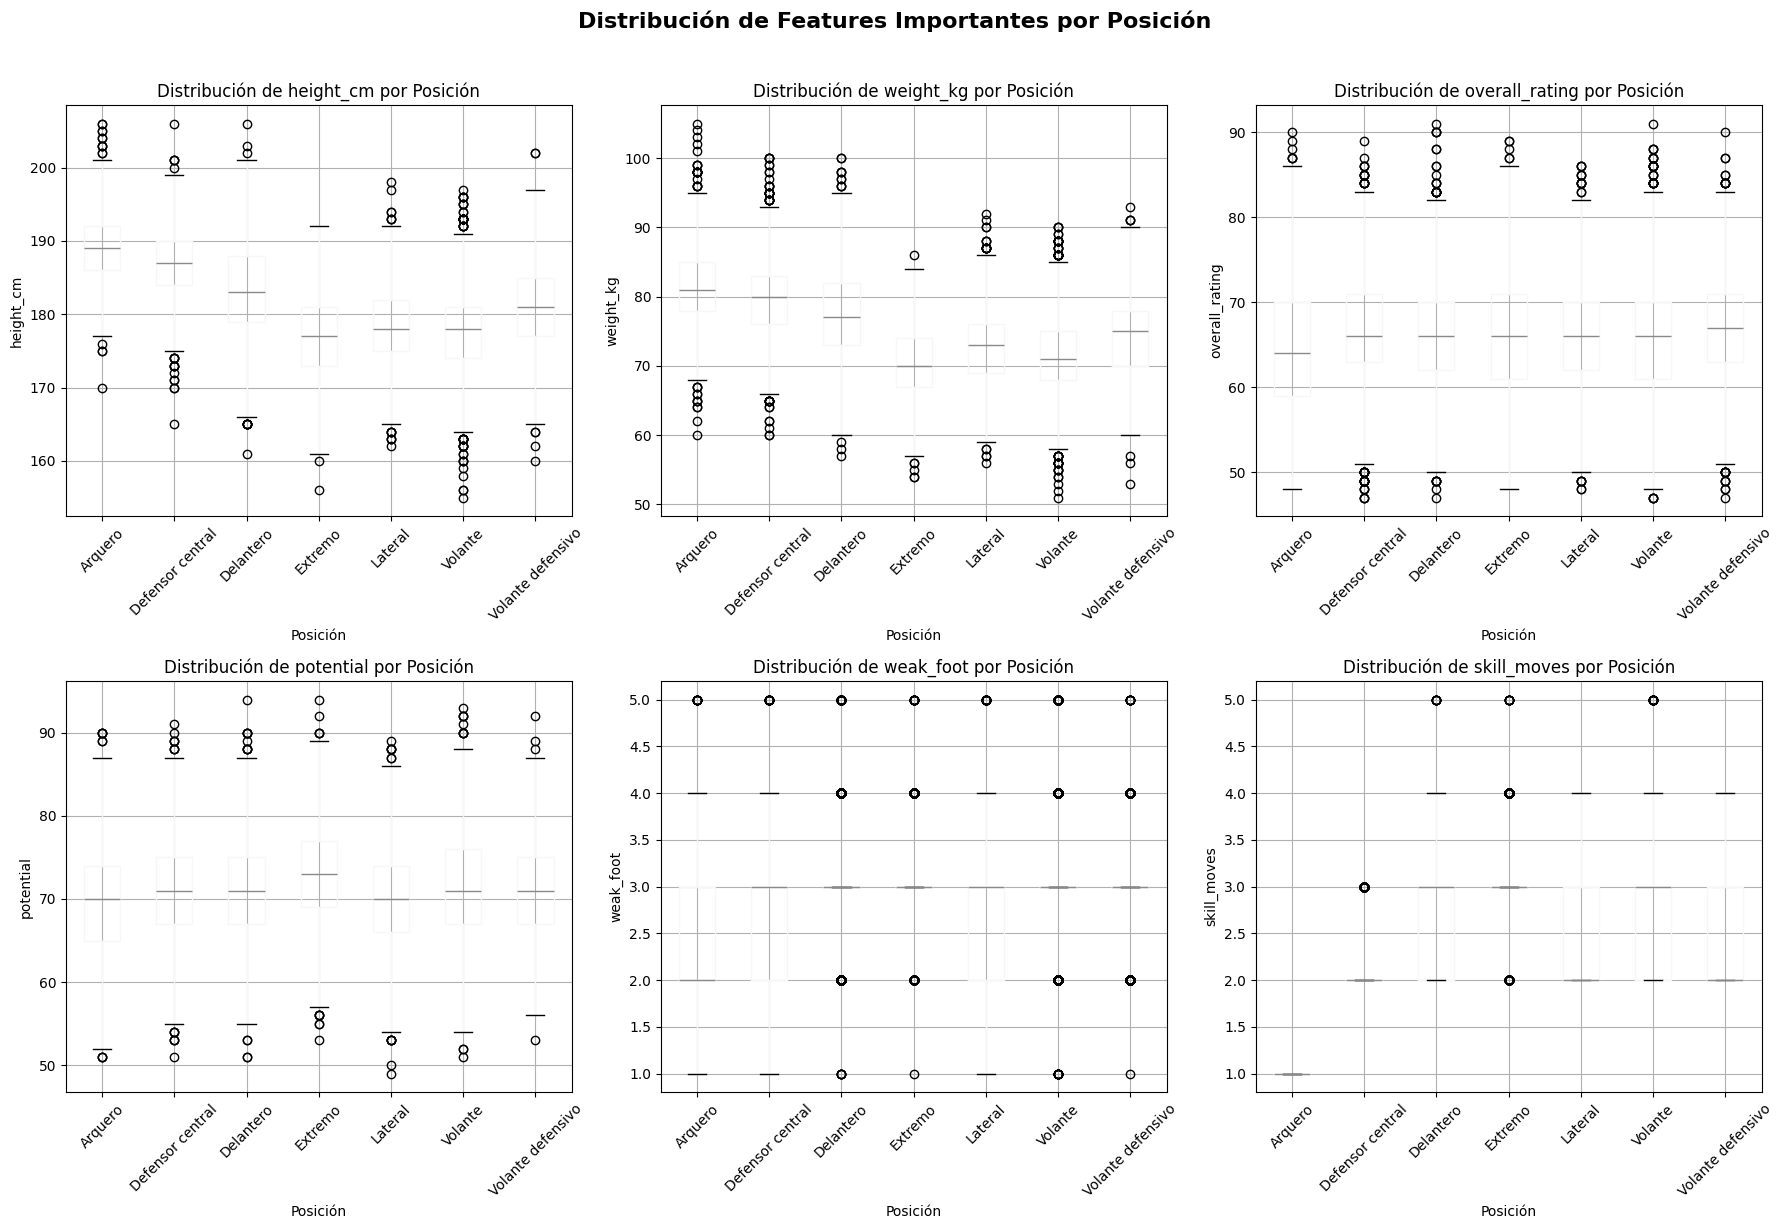

In [59]:
# Análisis de distribuciones por posición
print("📊 ANÁLISIS DE DISTRIBUCIONES POR POSICIÓN")
print("=" * 45)

# Seleccionar algunas features importantes para visualizar
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Usar las features más importantes
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = best_model.named_steps['selector'].selected_features_
    
    if 'feature_selection' in best_model.named_steps:
        selected_features = best_model.named_steps['feature_selection'].get_support()
        feature_names = [name for name, selected in zip(feature_names, selected_features) if selected]
    
    # Top 6 features más importantes
    top_features_idx = np.argsort(importances)[-6:]
    top_features = [feature_names[i] for i in top_features_idx]
else:
    # Si no hay importancia, usar features seleccionadas al azar
    feature_names = best_model.named_steps['selector'].selected_features_[:6]
    top_features = feature_names

print(f"Features seleccionadas para visualización: {top_features}")

# Crear subplots para cada feature
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    if feature in train_df.columns:
        # Boxplot por posición
        train_df.boxplot(column=feature, by='posicion', ax=axes[i])
        axes[i].set_title(f'Distribución de {feature} por Posición')
        axes[i].set_xlabel('Posición')
        axes[i].set_ylabel(feature)
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Distribución de Features Importantes por Posición', y=1.02, fontsize=16, fontweight='bold')
plt.show()


📊 MATRIZ DE CONFUSIÓN NORMALIZADA


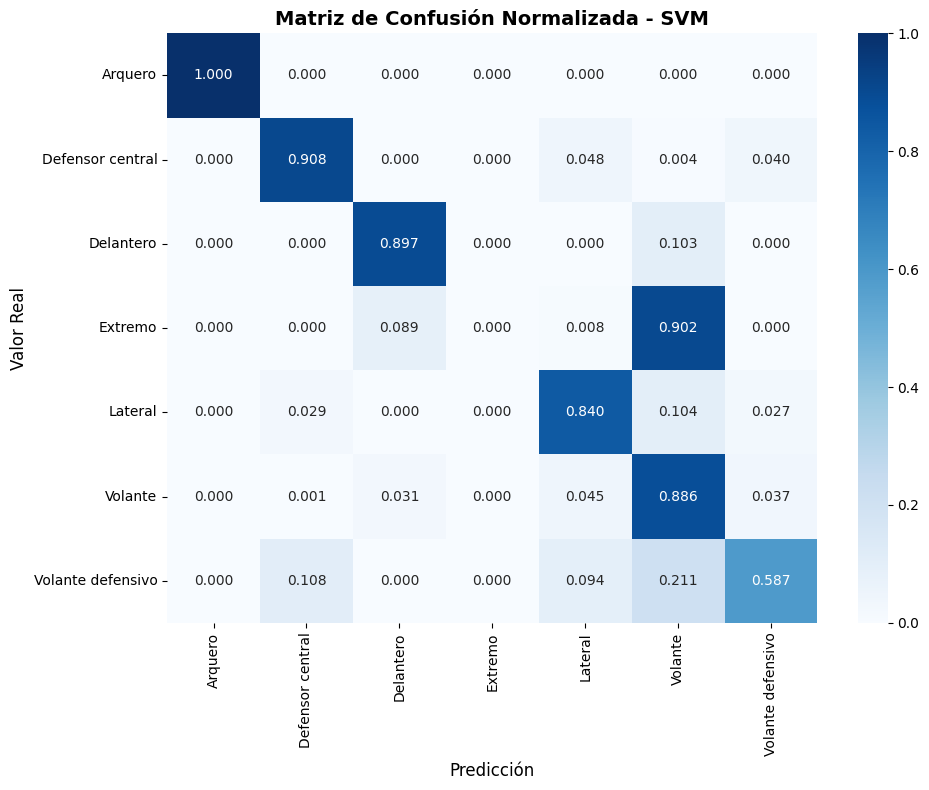


📋 Métricas por clase:


,Posición,Precisión,Recall,F1-Score,Support
0,Arquero,1.000,1.000,1.000,313
1,Defensor central,0.923,0.908,0.915,501
2,Delantero,0.909,0.897,0.903,399
3,Extremo,0.000,0.000,0.000,123
4,Lateral,0.819,0.840,0.829,443
5,Volante,0.743,0.886,0.808,807
6,Volante defensivo,0.679,0.587,0.630,223


In [60]:
# Matriz de confusión normalizada
print("📊 MATRIZ DE CONFUSIÓN NORMALIZADA")
print("=" * 40)

# Calcular matriz normalizada
cm_normalized = confusion_matrix(y_val, y_pred_best, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title(f'Matriz de Confusión Normalizada - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

# Análisis de precisión y recall por clase
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred_best)

metrics_df = pd.DataFrame({
    'Posición': classes,
    'Precisión': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n📋 Métricas por clase:")
display(metrics_df.round(3))


## 8. 📝 Resumen y conclusiones

Vamos a crear un resumen final del trabajo realizado.


In [61]:
print("📝 RESUMEN FINAL DEL TRABAJO PRÁCTICO")

print(f"\n🎯 OBJETIVO:")
print(f"   Clasificar posiciones de jugadores de FIFA usando atributos físicos y técnicos")

print(f"\n📊 DATASET:")
print(f"   • Entrenamiento: {train_df.shape}")
print(f"   • Test: {test_df.shape}")
print(f"   • Features seleccionadas: {len(best_model.named_steps['selector'].selected_features_)}")
print(f"   • Clases: {y.nunique()} posiciones diferentes")

print(f"\n🏗️ PIPELINE UTILIZADO:")
print(f"   • Feature Selection: {type(best_model.named_steps['selector']).__name__}")
print(f"   • Imputation: {type(best_model.named_steps['imputer']).__name__}")
print(f"   • Scaling: {type(best_model.named_steps['scaler']).__name__}")
if 'feature_selection' in best_model.named_steps:
    print(f"   • Feature Selection: {type(best_model.named_steps['feature_selection']).__name__}")
print(f"   • Classifier: {type(best_model.named_steps['classifier']).__name__}")

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   • Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")
print(f"   • CV Accuracy: {results[best_model_name]['cv_mean']:.4f} (±{results[best_model_name]['cv_std']:.4f})")

print(f"\n📈 MÉTRICAS DE EVALUACIÓN:")
print(f"   • Accuracy en validación: {results[best_model_name]['val_accuracy']:.4f}")
print(f"   • Matriz de confusión: Generada y visualizada")
print(f"   • Reporte de clasificación: Completado")
print(f"   • Validación cruzada: 5-fold implementada")

print(f"\n🎯 ENTREGABLES:")
print(f"   ✅ Pipeline completo implementado")
print(f"   ✅ Entrenamiento sin usar datos de test")
print(f"   ✅ Archivo submission.csv generado")
print(f"   ✅ Evaluación con accuracy y matriz de confusión")
print(f"   ✅ Visualizaciones incluidas")
print(f"   ✅ Notebook documentado paso a paso")

print(f"\n🚀 PRÓXIMOS PASOS:")
print(f"   1. Subir el notebook a Kaggle")
print(f"   2. Ejecutar el notebook en el entorno de Kaggle")
print(f"   3. Generar y enviar submission.csv")
print(f"   4. Compartir notebook con CienciaDatosUTNFRM")

print(f"\n🎉 ¡TRABAJO PRÁCTICO COMPLETADO EXITOSAMENTE!")
print(f"   Notebook listo para entregar en Kaggle")


📝 RESUMEN FINAL DEL TRABAJO PRÁCTICO

🎯 OBJETIVO:
   Clasificar posiciones de jugadores de FIFA usando atributos físicos y técnicos

📊 DATASET:
   • Entrenamiento: (14044, 49)
   • Test: (4682, 49)
   • Features seleccionadas: 40
   • Clases: 7 posiciones diferentes

🏗️ PIPELINE UTILIZADO:
   • Feature Selection: FeatureSelector
   • Imputation: SimpleImputer
   • Scaling: StandardScaler
   • Feature Selection: SelectKBest
   • Classifier: SVC

🏆 MEJOR MODELO: SVM
   • Validation Accuracy: 0.8345
   • CV Accuracy: 0.8199 (±0.0039)

📈 MÉTRICAS DE EVALUACIÓN:
   • Accuracy en validación: 0.8345
   • Matriz de confusión: Generada y visualizada
   • Reporte de clasificación: Completado
   • Validación cruzada: 5-fold implementada

🎯 ENTREGABLES:
   ✅ Pipeline completo implementado
   ✅ Entrenamiento sin usar datos de test
   ✅ Archivo submission.csv generado
   ✅ Evaluación con accuracy y matriz de confusión
   ✅ Visualizaciones incluidas
   ✅ Notebook documentado paso a paso

🚀 PRÓXIMOS P